# Combined Cost Analysis

We is the fun part. Now I will know the best time for my ski trip. I'm already excited. 

I just need to combine data for a 4 night stay ski trip for possible travel start date between 15th December 2018 and 7th April 2019. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.DataFrame(data={'date':pd.date_range(start='2018-12-15', end='2019-04-07')})
df['date'] = df['date'].astype(str)
# df = df.set_index('date')
# df['date'].head(1)

## Airbnb accommodation data

### Narrow down listing according to preferences
First, I narrow down the listing according to following criteria:
1. Number of people a listing accommodates: 2-4 (This would depend on how many people I am able to convince to join me on the trip).
2. Minimum listing rating of: 80
3. Room type: Entire home/apt

In [2]:
listing = pd.read_csv('../../Data/VacationPlanner/advanced_listing.csv')
idx = ((listing['accommodates'] >= 2) &
       (listing['accommodates'] <= 4) &
       (listing['review_scores_rating'] >= 90) &
       (listing['room_type'] >= 'Entire home/apt'))

selected_listing_id = listing[idx]['id']
listing = listing.set_index('id')

### Narrow down calendar price data to selected listing id

In [3]:
calendar = pd.read_csv('../../Data/VacationPlanner/advanced_calendar.csv')
calendar = calendar[calendar['id'].isin(selected_listing_id)]
calendar.head()
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121404 entries, 151 to 262739
Data columns (total 4 columns):
Unnamed: 0    121404 non-null int64
id            121404 non-null int64
date          121404 non-null object
price         111671 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.6+ MB


### Compile total median Airbnb cost 

For each start date between 15th December 2018 and 7th April 2019, compile the total median cost of all the listing in which I could potentially stay for 4 consecutive nights


In [4]:
def median_airbnb_cost(start_date):
    
    # Find end date
    df_ = pd.DataFrame(data={'date':pd.date_range(start=start_date, periods=4)})
    end_date = df_['date'].astype(str).tolist()[-1]
    
    # Collect all listing between start and end date
    sub_calendar = calendar[(calendar['date'] >= start_date) &
                           (calendar['date'] <= end_date)]
    
    # Find listings which are not available for all the 4 nights
    invalid_id = sub_calendar[sub_calendar['price'].isnull()]['id'].unique()
    
    # Sum of price to stay at a listing
    df_local = sub_calendar.groupby('id').sum()
    
    # Remove invalid id
    df_local = df_local[~df_local.index.isin(invalid_id)]
    
    # Compure price person for the valid listings
    df_local['id'] = df_local.index
    df_local.reset_index(drop=True)
    df_local['cleaning_fee'] = df_local['id'].apply(lambda x: listing.loc[x, 'cleaning_fee'])
    df_local['accommodates'] = df_local['id'].apply(lambda x: listing.loc[x, 'accommodates'])
    df_local['price'] = (df_local['price'] + df_local['cleaning_fee'])/df_local['accommodates']
    
    return df_local['price'].median()

df['Airbnb_cost'] = df['date'].apply(median_airbnb_cost)

In [5]:
# plt.plot(df['date'], df['Airbnb cost'])
df.head()

,date,Airbnb_cost
0,2018-12-15,148.333333
1,2018-12-16,147.250000
2,2018-12-17,147.000000
3,2018-12-18,147.500000
4,2018-12-19,150.000000


## Flight price data

To df add the flight price for the given start date with 4 nights of stay

In [6]:
flight_price = pd.read_csv('../../Data/VacationPlanner/flight_price.csv')
flight_price = flight_price.set_index('date')

df['fly_Madison'] = df['date'].apply(lambda x: flight_price.loc[x, 'Madison'])
df['fly_Chicago'] = df['date'].apply(lambda x: flight_price.loc[x, 'Chicago'])

df.head()

,date,Airbnb_cost,fly_Madison,fly_Chicago
0,2018-12-15,148.333333,261.0,277.0
1,2018-12-16,147.250000,267.0,312.0
2,2018-12-17,147.000000,415.0,305.0
3,2018-12-18,147.500000,261.0,332.0
4,2018-12-19,150.000000,381.0,287.0


## Vacation day and Peak travel cost

To add the per day vacation day and peak travel cost for 5 days during the trip. 

In [7]:
vacationday_peaktravel = pd.read_csv('../../Data/VacationPlanner/peaktravel_vacationday_cost.csv')
vacationday_peaktravel = vacationday_peaktravel.set_index('date')

def cumulative_cost(start_date):
    
    # Find end date
    df_ = pd.DataFrame(data={'date':pd.date_range(start=start_date, periods=5)})
    end_date = df_['date'].astype(str).tolist()[-1]
    
    # Slice all cost between start and end date
    sub_df = vacationday_peaktravel.loc[start_date:end_date, ['vacation_day_cost', 'peak_travel_cost']]
    
    return sub_df.sum().sum()

df['other_cost'] = df['date'].apply(cumulative_cost)

df.head()

,date,Airbnb_cost,fly_Madison,fly_Chicago,other_cost
0,2018-12-15,148.333333,261.0,277.0,230
1,2018-12-16,147.250000,267.0,312.0,285
2,2018-12-17,147.000000,415.0,305.0,340
3,2018-12-18,147.500000,261.0,332.0,345
4,2018-12-19,150.000000,381.0,287.0,350


## Weather data

Collect the snowth depth and average temperature data for all the dates in trip planning range.

In [8]:
weather = pd.read_csv('../../Data/VacationPlanner/weather_trend.csv')
weather = weather.set_index('date')

df['snwd'] = df['date'].apply(lambda x: weather.loc[x, 'SNWD'])
df['temp'] = df['date'].apply(lambda x: weather.loc[x, 'TAVG'])
df['snwd_std'] = df['date'].apply(lambda x: weather.loc[x, 'SNWD_STD'])
df['temp_std'] = df['date'].apply(lambda x: weather.loc[x, 'TAVG_STD'])

df.head()

,date,Airbnb_cost,fly_Madison,fly_Chicago,other_cost,snwd,temp,snwd_std,temp_std
0,2018-12-15,148.333333,261.0,277.0,230,12.275755,-4.920127,6.828423,4.880020
1,2018-12-16,147.250000,267.0,312.0,285,12.834855,-5.082164,8.253375,4.865153
2,2018-12-17,147.000000,415.0,305.0,340,13.236365,-5.323830,8.451981,4.845598
3,2018-12-18,147.500000,261.0,332.0,345,13.623114,-5.404386,8.662577,4.740186
4,2018-12-19,150.000000,381.0,287.0,350,14.000591,-5.375682,8.825957,4.654949


### Total cost to fly from Madison or Chicago

In [9]:
df['Madison'] = df['fly_Madison'] + df['other_cost'] + df['Airbnb_cost']
df['Chicago'] = df['fly_Chicago'] + df['other_cost'] + df['Airbnb_cost']

## Find the cheapest travel start date

In [25]:
cheapest_price = df[['Madison', 'Chicago']].min().min()


# Visualize

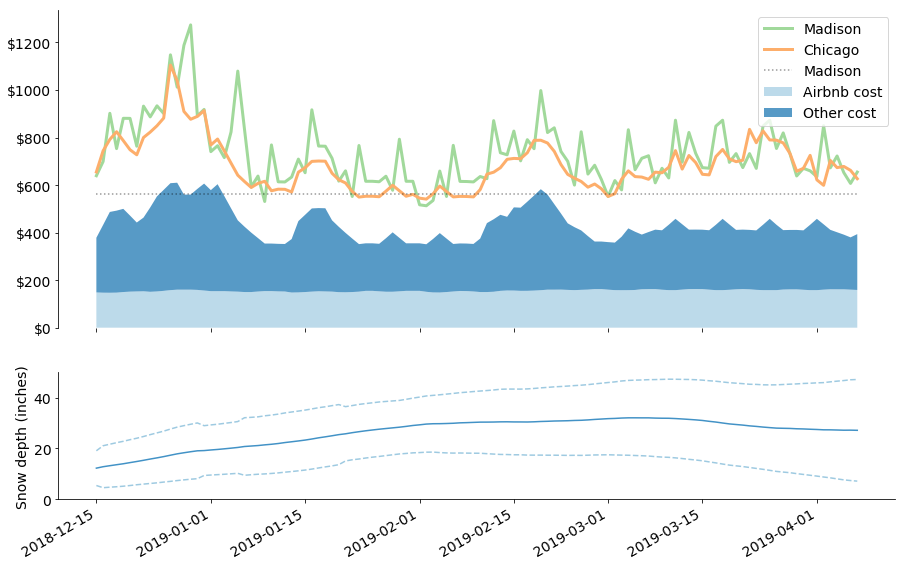

In [30]:
fig, ax = plt.subplots(2,1, sharex=True, figsize = (15,10),
                        gridspec_kw = {'height_ratios':[3, 1.2]})
plt.rcParams.update({'font.size': 14})

# First subplot has stacked price cost for line plot for flight ticket from Madison and Chicago
labels = ["Airbnb cost", "Other cost"]
colors = ['#a6cee3', '#1f78b4']

ax[0].stackplot(df['date'], 
                df['Airbnb_cost'],
                df['other_cost'],
                labels=labels,
                colors=colors, 
                alpha=0.75)
ax[0].plot(df['date'], df['Madison'], 'k', color='#a1d99b', linewidth=3)
ax[0].plot(df['date'], df['Chicago'], 'k', color='#fdae6b', linewidth=3)
ax[0].plot(df['date'], 0*df['Madison']+cheapest_price+50, ':k', alpha=0.4)
ax[0].legend(fontsize=14, loc='upper right')
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].set_yticklabels(['${0:0.0f}'.format(x) for x in ax[0].get_yticks()])

# Draw snowdepth plot
lower = df['snwd'] - df['snwd_std']
lower[lower<0] = 0
upper = df['snwd'] + df['snwd_std']
# ax[1].fill_between(df['date'], lower*0, df['snwd'],
#             alpha=0.1, facecolor='#deebf7')
# ax[1].fill_between(df['date'], df['snwd'], upper,
#             alpha=0.1, facecolor='#f7fbff')
ax[1].plot(df['date'], lower, '--', color='#9ecae1')
ax[1].plot(df['date'], upper, '--', color='#9ecae1')
ax[1].plot(df['date'], df['snwd'], 'k', color='#4292c6')
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].set_ylabel('Snow depth (inches)', fontdict={'size':14});
ax[1].set_ylim(0,50)

xticks = ['2018-12-15', '2019-01-01', '2019-01-15', '2019-02-01', '2019-02-15', '2019-03-01', 
          '2019-03-15', '2019-04-01']
ax[1].set_xticks(xticks)

fig.autofmt_xdate()